In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
## stating

In [22]:
import torch  
import torch.nn as nn 
from torch.optim import Adam 
from torch.utils.data import DataLoader , Dataset 
from torchsummary import summary 

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 

device = 'cuda' if torch.cuda.is_available() else 'cpu' 
device

'cuda'

In [24]:
data_path = '/kaggle/input/rice-type-classification/riceClassification.csv'
data_df = pd.read_csv(data_path) 
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [26]:
data_df.isna().sum()

id                 0
Area               0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Perimeter          0
Roundness          0
AspectRation       0
Class              0
dtype: int64

In [29]:
data_df.drop_duplicates(inplace=True)

In [32]:
data_df.sample(5)

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
4155,4156,6468,154.621866,53.785361,0.937550,6621,90.748627,0.500309,344.258,0.685823,2.874795,1
6888,6889,6800,164.007018,53.960509,0.944325,7031,93.048530,0.636943,367.344,0.633247,3.039390,1
3337,3338,5955,110.688311,70.978597,0.767334,6062,87.075493,0.608274,295.812,0.855185,1.559460,0
16102,16103,7795,151.297073,66.526174,0.898142,7971,99.623804,0.721492,358.859,0.760638,2.274249,0
6400,6401,6581,160.112980,53.192003,0.943204,6734,91.537913,0.481490,354.198,0.659188,3.010095,1


In [33]:
data_df.drop(columns=['id'],inplace=True)

In [37]:
data_df['Class'].value_counts()

Class
1    9985
0    8200
Name: count, dtype: int64

In [39]:
original_df = data_df.copy() 

for column_name in data_df.columns: 
    data_df[column_name] = data_df[column_name]/data_df[column_name].abs().max() 

data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [44]:
X = np.array(data_df.iloc[: , :-1]) 
Y= np.array(data_df.iloc[:  , -1]) 
Y

array([1., 1., 1., ..., 0., 0., 0.])

In [45]:
X_train , X_test , y_train , y_test = train_test_split(X , Y , test_size=0.3 , random_state=42) 

# for test and val 
X_test , X_val , y_test , y_val = train_test_split(X_test , y_test , test_size=0.3 , random_state=42) 


In [47]:
print(X_train.shape) 
print(X_test.shape) 
print(X_val.shape) 

(12729, 10)
(3819, 10)
(1637, 10)


### now we have to convert the data to torch dataset 



In [49]:
## to create numpy arrays to dataset we have to use dataset 
class dataset(Dataset): 
    def __init__(self , X , Y): 
        self.X = torch.tensor(X , dtype=torch.float32).to(device)
        self.Y = torch.tensor(Y , dtype=torch.float32).to(device) 

    def __len__(self): 
        return len(self.X) 

    def __getitem__(self , index): 
        return self.X[index] , self.Y[index] 

training_datset = dataset(X_train , y_train) 
test_dataset  = dataset(X_test , y_test)
validation_dataset = dataset(X_val ,y_val )

### Dataloaders 
- instead of load complete data ones load data in batches for effective memory management and no memory crash

In [50]:
train_dataloader = DataLoader(training_datset, batch_size=8 , shuffle=True ) 
test_dataloader = DataLoader(test_dataset, batch_size=8 , shuffle=True ) 
val_dataloader = DataLoader(validation_dataset, batch_size=8 , shuffle=True ) 


In [51]:
for x , y in train_dataloader: 
    print(x) 
    print("=="*10) 
    print(y) 
    break 

## here you see all batches contain 8 rows 

tensor([[0.7411, 0.7753, 0.8314, 0.9056, 0.7028, 0.8609, 0.6703, 0.6789, 0.8818,
         0.5291],
        [0.6189, 0.8162, 0.6579, 0.9638, 0.5872, 0.7867, 0.6000, 0.6701, 0.7559,
         0.7039],
        [0.8862, 0.8725, 0.8873, 0.9194, 0.8458, 0.9414, 0.7040, 0.7566, 0.8489,
         0.5579],
        [0.6974, 0.9233, 0.6573, 0.9797, 0.6682, 0.8351, 0.5290, 0.7520, 0.6763,
         0.7969],
        [0.5422, 0.7811, 0.6124, 0.9677, 0.5174, 0.7364, 0.7312, 0.6383, 0.7299,
         0.7236],
        [0.9550, 0.9008, 0.9264, 0.9166, 0.9146, 0.9773, 0.6957, 0.7834, 0.8535,
         0.5517],
        [0.9196, 0.9287, 0.8616, 0.9397, 0.8737, 0.9590, 0.7212, 0.7907, 0.8067,
         0.6115],
        [0.7842, 0.8186, 0.8345, 0.9188, 0.7438, 0.8856, 0.6509, 0.7045, 0.8666,
         0.5566]], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 0.], device='cuda:0')


In [119]:
class MyModel(nn.Module): 
    def __init__(self): 
        super(MyModel , self).__init__() 

        self.relu = nn.ReLU()
        self.input_layer = nn.Linear(X.shape[1] , 64) 
        self.layer2 = nn.Linear(64 , 32)  
        self.layer3 =nn.Linear(32 , 1) 
        self.sigmoid = nn.Sigmoid() 

    def forward(self,x): ## it is for how data flow from forward method 
        x = self.relu(self.input_layer(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        x = self.sigmoid(x) 
        return x  

model = MyModel().to(device) 
summary(model , (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             704
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 32]           2,080
              ReLU-4                   [-1, 32]               0
            Linear-5                    [-1, 1]              33
           Sigmoid-6                    [-1, 1]               0
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [120]:
## define the losses 
criterion = nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters() , lr=1e-2) 
# optimizer

In [121]:
total_loss_train_plot = [] 
total_loss_validation_plot = [] 
total_acc_train_plot = [] 
total_acc_validation_plot = [] 

epochs=10 
for epoch in range(epochs): 
    total_train_loss = 0 
    total_train_acc = 0 
    total_val_acc = 0 
    total_val_loss = 0  
    for data in train_dataloader: 
        inputs , label = data 
        prediction = model(inputs).squeeze(1)
        # print(prediction.shape) ## it give [8,1]  no need of 1 extra dimension remove it by squeeze 
        # print(prediction.squeeze(1).shape) 
        batch_loss = criterion(prediction , label) 
        total_train_loss += batch_loss.item()

        acc = ((prediction).round() == label).sum().item()
        total_train_acc +=  acc  
        
        batch_loss.backward() ## backpropagrate all the loss through the network 
        optimizer.step()  ## optimizer please take the step 
        optimizer.zero_grad() 

    ## Validation time 
    with torch.no_grad(): 
        for data in val_dataloader: 
            inputs , label  = data 
            prediction = model(inputs).squeeze(1) 
            val_loss = criterion(prediction , label) 
            total_val_loss += val_loss.item() 

            val_acc = ((prediction).round() == label).sum().item() 
            total_val_acc += val_acc
        
    total_loss_train_plot.append(round(total_train_loss / 100 , 4)) 
    total_loss_validation_plot.append(round(total_val_loss / 100,4))
    total_acc_train_plot.append(round(total_train_acc/training_datset.__len__() *100 , 4))
    total_acc_validation_plot.append(round(total_val_acc/ validation_dataset.__len__() *100 , 4)) 


    print(f"Epoch no. {epoch+1}|| train loss :{round(total_train_loss / 100 , 4)}||Train Accuracy {round(total_train_acc/training_datset.__len__() *100 , 4)} ||")
    print(f"val loss :{round(total_val_loss / 100,4)}||Val Accuracy {round(total_val_acc/ validation_dataset.__len__() *100 , 4)} ||") 
    print(f"=="*30)

Epoch no. 1|| train loss :1.4925||Train Accuracy 96.4491 ||
val loss :0.1117||Val Accuracy 98.2896 ||
Epoch no. 2|| train loss :0.9468||Train Accuracy 97.9024 ||
val loss :0.4793||Val Accuracy 91.3867 ||
Epoch no. 3|| train loss :0.882||Train Accuracy 98.0517 ||
val loss :0.1573||Val Accuracy 98.2896 ||
Epoch no. 4|| train loss :0.8537||Train Accuracy 98.201 ||
val loss :0.113||Val Accuracy 98.3506 ||
Epoch no. 5|| train loss :0.8328||Train Accuracy 98.256 ||
val loss :0.1121||Val Accuracy 98.3506 ||
Epoch no. 6|| train loss :0.843||Train Accuracy 98.2638 ||
val loss :0.1322||Val Accuracy 98.1674 ||
Epoch no. 7|| train loss :0.8649||Train Accuracy 98.1145 ||
val loss :0.1221||Val Accuracy 98.0452 ||
Epoch no. 8|| train loss :0.8183||Train Accuracy 98.1852 ||
val loss :0.1286||Val Accuracy 98.2285 ||
Epoch no. 9|| train loss :0.8198||Train Accuracy 98.2481 ||
val loss :0.1114||Val Accuracy 98.4117 ||
Epoch no. 10|| train loss :0.7958||Train Accuracy 98.2402 ||
val loss :0.1603||Val Accu

In [122]:
with torch.no_grad(): 
    total_loss_test = 0 
    total_acc_test = 0 
    for data in test_dataloader: 
        inputs , labels  = data 
        prediction = model(inputs).squeeze(1) 
        batch_loss_test = criterion(prediction , labels).item()
        total_loss_test += batch_loss_test 
        acc = ((prediction).round() == labels).sum().item() 
        total_acc_test += acc 
print(f"test accuracy :{round(total_acc_test / test_dataset.__len__() , 4)}||test loss {round(total_loss_test/test_dataset.__len__()  , 4)} ||")


test accuracy :0.9811||test loss 0.0067 ||


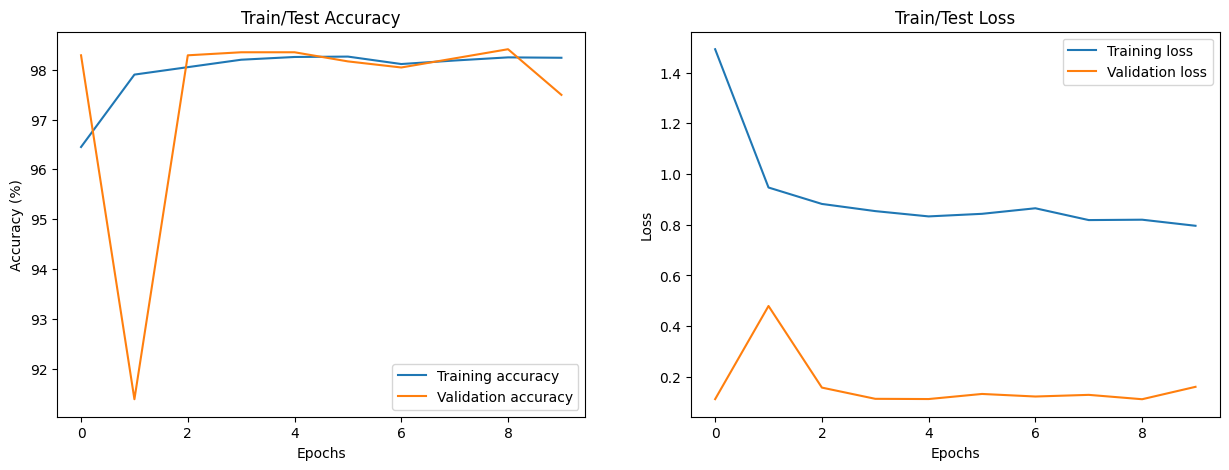

In [126]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# Accuracy plot
ax[0].plot(total_acc_train_plot, label='Training accuracy')
ax[0].plot(total_acc_validation_plot, label='Validation accuracy')
ax[0].set_title('Train/Test Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy (%)')
ax[0].legend()

# Loss plot
ax[1].plot(total_loss_train_plot, label='Training loss')
ax[1].plot(total_loss_validation_plot, label='Validation loss')
ax[1].set_title('Train/Test Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()



### **Conclusion**

* **Training accuracy** steadily increases and stabilizes around **98–99%**, showing the model learns well.
* **Validation accuracy** closely follows training accuracy, meaning **no major overfitting**.
* **Training loss** consistently decreases → good optimization.
* **Validation loss** is low and stable → model generalizes well.
* The small fluctuations in validation accuracy/loss are normal and not concerning.

👉 **Overall:** Your model is performing well, with **strong learning, good generalization, and no signs of overfitting**.


## inference the Model

In [193]:
import torch
import random

# pick random row
rand = random.randint(0, data_df.shape[0] - 1)

# actual label
actual_label = data_df.iloc[rand, -1]

# input features
input_values = data_df.iloc[rand, :-1].values
input_tensor = torch.tensor(input_values, dtype=torch.float32).unsqueeze(0).to(device)
# shape becomes (1, num_features)

model.eval()
with torch.no_grad():
    pred = model(input_tensor).item()   # output is a single float
    predicted_class = 1 if pred >= 0.5 else 0

print("Actual Label:", actual_label)
print("Predicted Probability:", pred)
print("Predicted Class:", predicted_class)


Actual Label: 1.0
Predicted Probability: 0.9999480247497559
Predicted Class: 1


In [172]:
data_df

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0
...,...,...,...,...,...,...,...,...,...,...,...
18180,0.573262,0.811219,0.618156,0.971489,0.545785,0.757140,0.562384,0.654774,0.733291,0.744543,0.0
18181,0.742899,0.925674,0.704314,0.971683,0.709121,0.861916,0.730296,0.758107,0.708884,0.745661,0.0
18182,0.623408,0.844800,0.640916,0.972058,0.593296,0.789562,0.633098,0.673049,0.754720,0.747830,0.0
18183,0.583741,0.826356,0.623551,0.972748,0.562227,0.764030,0.555396,0.675248,0.702103,0.751874,0.0


---
---

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/animal-faces")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/d/andrewmvd/animal-faces


In [2]:
import torch 
import  torch.nn as nn 
from torch.optim import Adam 
from torchvision.transforms import transforms 
from torch.utils.data import DataLoader , Dataset 
from sklearn.preprocessing import LabelEncoder 
import matplotlib.pyplot as plt 
from PIL import Image 
import pandas as pd 
import numpy as np 
import os
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
device

'cuda'

In [4]:
image_paths, labels = [], []

main_directory = '/kaggle/input/d/andrewmvd/animal-faces/afhq'

for split in os.listdir(main_directory):  # train, val, test
    split_dir = os.path.join(main_directory, split)
    
    if not os.path.isdir(split_dir):
        continue
    
    for label in os.listdir(split_dir):  # cat, dog, wild
        class_dir = os.path.join(split_dir, label)

        if not os.path.isdir(class_dir):
            continue

        for img in os.listdir(class_dir):  # actual files
            if img.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(os.path.join(class_dir, img))  # ✔ correct
                labels.append(label)


In [5]:
## create a data frame for easy manupulation 
df = pd.DataFrame(zip(image_paths , labels) , columns=['image_path' , 'label'])
df.head()

,image_path,label
0,/kaggle/input/d/andrewmvd/animal-faces/afhq/va...,dog
1,/kaggle/input/d/andrewmvd/animal-faces/afhq/va...,dog
2,/kaggle/input/d/andrewmvd/animal-faces/afhq/va...,dog
3,/kaggle/input/d/andrewmvd/animal-faces/afhq/va...,dog
4,/kaggle/input/d/andrewmvd/animal-faces/afhq/va...,dog


In [6]:
df['label'].value_counts()

label
cat     5653
dog     5239
wild    5238
Name: count, dtype: int64

In [7]:
train = df.sample(frac=0.7) 
test = df.drop(train.index) 

val = test.sample(frac=0.5) 
test = test.drop(val.index) 
print(train.shape)
print(val.shape)
print(test.shape)

(11291, 2)
(2420, 2)
(2419, 2)


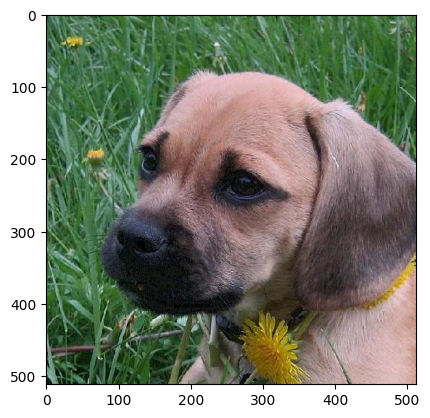

In [8]:
im = plt.imread(train['image_path'][10]) 
plt.imshow(im)

In [9]:
train

,image_path,label
5812,/kaggle/input/d/andrewmvd/animal-faces/afhq/tr...,dog
1484,/kaggle/input/d/andrewmvd/animal-faces/afhq/va...,cat
15775,/kaggle/input/d/andrewmvd/animal-faces/afhq/tr...,cat
13370,/kaggle/input/d/andrewmvd/animal-faces/afhq/tr...,cat
9048,/kaggle/input/d/andrewmvd/animal-faces/afhq/tr...,wild
...,...,...
1181,/kaggle/input/d/andrewmvd/animal-faces/afhq/va...,cat
9375,/kaggle/input/d/andrewmvd/animal-faces/afhq/tr...,wild
7936,/kaggle/input/d/andrewmvd/animal-faces/afhq/tr...,wild
4957,/kaggle/input/d/andrewmvd/animal-faces/afhq/tr...,dog


In [10]:
label_encoder = LabelEncoder() 
label_encoder.fit(df['label']) 

## now we transforms iamges to tensors 
transform = transforms.Compose([
    transforms.Resize((128,128)) , 
    transforms.ToTensor() , 
    transforms.ConvertImageDtype(torch.float)
])

In [11]:
class CustomImageDataset(Dataset): 
    def __init__(self , dataframe , transform=None): 
        # super.__init__(CustomImageDataset , self) 
        self.dataframe = dataframe 
        self.transform = transform 
        self.labels = torch.tensor(label_encoder.transform(dataframe['label'])).to(device) 
    def __len__(self): 
        return self.dataframe.shape[0]  ## it just have to return the rows in the dataframe 

    def __getitem__(self , idx): 
        img_path = self.dataframe.iloc[idx , 0] # for image path 
        label = self.labels[idx] 

        image = Image.open(img_path).convert('RGB') 
        if self.transform: 
            image = self.transform(image).to(device) 
        return image , label

In [12]:
train_dataset = CustomImageDataset(dataframe = train , transform=transform)
val_dataset = CustomImageDataset(dataframe = val , transform=transform)
test_dataset = CustomImageDataset(dataframe = test , transform=transform)

In [13]:
train_dataset.__getitem__(9)

(tensor([[[0.0980, 0.0863, 0.0588,  ..., 0.1451, 0.1294, 0.1098],
          [0.0784, 0.0784, 0.0706,  ..., 0.1843, 0.1922, 0.1686],
          [0.0784, 0.0863, 0.0941,  ..., 0.2039, 0.2000, 0.2039],
          ...,
          [0.4392, 0.4275, 0.3843,  ..., 0.4353, 0.4157, 0.3922],
          [0.4078, 0.4000, 0.3843,  ..., 0.4118, 0.4078, 0.4314],
          [0.4157, 0.3922, 0.3529,  ..., 0.4039, 0.3922, 0.4196]],
 
         [[0.2824, 0.2824, 0.2745,  ..., 0.3020, 0.2980, 0.3098],
          [0.2863, 0.2941, 0.2902,  ..., 0.3725, 0.3686, 0.3647],
          [0.3255, 0.3255, 0.3255,  ..., 0.4196, 0.4078, 0.4235],
          ...,
          [0.3373, 0.3216, 0.2902,  ..., 0.3922, 0.3725, 0.3647],
          [0.3059, 0.3137, 0.3059,  ..., 0.3882, 0.3725, 0.3765],
          [0.3255, 0.3333, 0.3020,  ..., 0.3843, 0.3686, 0.3725]],
 
         [[0.1059, 0.0941, 0.0627,  ..., 0.1255, 0.1059, 0.0784],
          [0.1059, 0.1059, 0.0941,  ..., 0.2000, 0.1922, 0.1608],
          [0.1059, 0.1137, 0.1216,  ...,

In [14]:
label_encoder.inverse_transform([0]),label_encoder.inverse_transform([1]),label_encoder.inverse_transform([2])

(array(['cat'], dtype=object),
 array(['dog'], dtype=object),
 array(['wild'], dtype=object))

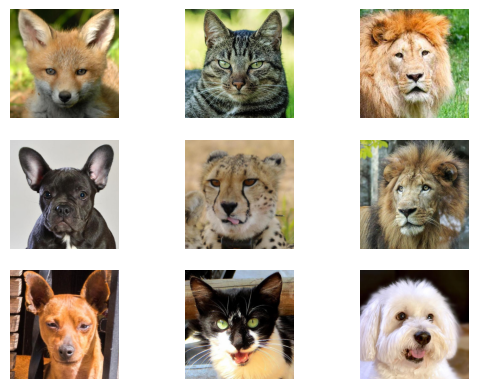

In [15]:
n_rows , n_cols = 3 ,3 

f , axarr = plt.subplots(n_rows , n_cols )
for row in range(n_rows) : 
    for col in range(n_cols): 
        image = Image.open(df.sample(n=1)['image_path'].iloc[0]).convert('RGB') 
        axarr[row , col].imshow(image) 
        axarr[row , col].axis('off') 
plt.show()

In [16]:
LEARNING_RATE = 1e-3 
BATCH_SIZE = 32 
EPOCHS = 10

In [17]:
train_loader= DataLoader(train_dataset , batch_size=BATCH_SIZE , shuffle=True)
val_loader  = DataLoader(val_dataset , batch_size=BATCH_SIZE , shuffle=True)
test_loader = DataLoader(test_dataset , batch_size = BATCH_SIZE , shuffle=True)

In [18]:
## creating the neural net 
class Net(nn.Module): 
    def __init__(self):
        super().__init__() 
        
        self.conv1 = nn.Conv2d(3 , 32 , kernel_size=3 , padding=1) 
        self.conv2 = nn.Conv2d(32 , 64 , kernel_size=3 , padding=1) 
        self.conv3 = nn.Conv2d(64 , 128 , kernel_size=3 , padding=1) 
        
        self.pooling = nn.MaxPool2d(2,2) 
        self.relu = nn.ReLU() 
        
        self.flatten = nn.Flatten() 
        self.Linear = nn.Linear(128*16*16, 128)
        self.output = nn.Linear(128  ,len(df['label'].unique()))
        
    def forward(self , x): 
        x = self.conv1(x) # (32 , 128 , 128)
        x = self.pooling(x) # (32 , 64 , 64) ## why 64 of 128 beacause we use pooling where we keep the kernel size to be 2 bcz it divide by 2
        x = self.relu(x)  # (32 , 64 , 64)
        x = self.relu(self.pooling(self.conv2(x))) # (64 , 32,32)
        x = self.relu(self.pooling(self.conv3(x)))  # (128 , 16 ,16)
        # print(f"shape of x before flatten layer : {x.shape}")
        x = self.flatten(x)  
        # print(f"shape of flatten layer : " , x.shape)
        x = self.Linear(x)
        output = self.output(x) 
        return output 
    
model = Net().to(device)

In [19]:
from torchsummary import summary 

summary(model, input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [24]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters() , lr=LEARNING_RATE)  
EPOCHS

10

In [26]:
### Training Loop 
total_training_loss_plot = [] 
total_training_accuracy_plot = [] 
total_validation_loss_plot = [] 
total_Validation_accuracy_plot = [] 
print("Training Started")
for epoch in range(EPOCHS):   
    print(f"Current Epoch {epoch+1} ......")
    total_training_loss = 0
    total_training_accuracy = 0 
    total_validation_loss = 0
    total_Validation_accuracy = 0 
    
    for inputs , labels in train_loader: 
        # optimizer.zero_grad()  
        model.train() 
        inputs = inputs.to(device)      # FIX
        labels = labels.to(device)      # FIX
        
        pred = model(inputs) 
        train_loss = criterion(pred , labels) 
        
        total_training_loss += train_loss.item() 
        train_loss.backward()   
        
        train_acc = (torch.argmax(pred , dim=1) == labels).sum().item()   # sum brings us the how much value true and item give the value 
        
        total_training_accuracy += train_acc 
        optimizer.step()
        optimizer.zero_grad()  
        # print(f"training accuracy : {train_acc}") 
    with torch.no_grad(): 
        model.eval()
        for inputs , labels in val_loader: 
            inputs = inputs.to(device)      # FIX
            labels = labels.to(device)      # FIX
            outputs = model(inputs) 
            val_loss = criterion(outputs , labels) 
            total_validation_loss += val_loss.item()
            
            val_acc = (torch.argmax(outputs , dim=1)==labels).sum().item() 
            total_Validation_accuracy += val_acc
            
    total_training_loss_plot.append(round(total_training_loss/1000 , 4))
    total_training_accuracy_plot.append((total_training_accuracy / train_dataset.__len__()) * 100)
    total_validation_loss_plot.append(round(total_validation_loss/1000 , 4))
    total_Validation_accuracy_plot.append((total_Validation_accuracy / val_dataset.__len__())*100)  
    train_percent = (total_training_accuracy / train_dataset.__len__()) * 100
    val_percent = (total_Validation_accuracy / val_dataset.__len__()) * 100
    print(f"""Epoch {epoch+1}/{EPOCHS} 
Training accuracy : {train_percent:.2f}% | Training Loss : {total_training_loss:.4f} |
Val accuracy : {val_percent:.2f}% | Val Loss {total_validation_loss:.4f}""")

Training Started
Current 1 ......
Epoch 1/10 
Training accuracy : 98.89% | Training Loss : 11.2650 |
Val accuracy : 95.33% | Val Loss 14.3980
Current 2 ......
Epoch 2/10 
Training accuracy : 98.95% | Training Loss : 9.8638 |
Val accuracy : 95.33% | Val Loss 13.0743
Current 3 ......
Epoch 3/10 
Training accuracy : 99.25% | Training Loss : 7.5804 |
Val accuracy : 94.71% | Val Loss 21.0463
Current 4 ......
Epoch 4/10 
Training accuracy : 98.49% | Training Loss : 13.6084 |
Val accuracy : 94.30% | Val Loss 19.7769
Current 5 ......
Epoch 5/10 
Training accuracy : 99.50% | Training Loss : 5.7818 |
Val accuracy : 95.91% | Val Loss 16.1838
Current 6 ......
Epoch 6/10 
Training accuracy : 99.45% | Training Loss : 5.7765 |
Val accuracy : 95.04% | Val Loss 17.1783
Current 7 ......
Epoch 7/10 
Training accuracy : 99.22% | Training Loss : 7.1695 |
Val accuracy : 95.21% | Val Loss 18.8926
Current 8 ......
Epoch 8/10 
Training accuracy : 99.57% | Training Loss : 4.1274 |
Val accuracy : 95.91% | Val Lo

In [32]:
with torch.no_grad(): 
    total_loss_test = 0 
    total_acc_test  = 0 
    for inputs , label in test_loader:   
        inputs = inputs.to(device) 
        label = label.to(label)
        pred = model(inputs) 
        test_loss = criterion(pred , label)  

        acc = (torch.argmax(pred , dim=1)==label).sum().item() 
        total_loss_test += test_loss.item() 
        total_acc_test += acc 
    test_accu = (total_acc_test / test_dataset.__len__()) * 100 
    
print(f"Test accuracy : {test_accu:.2f}% | Test Loss : {total_loss_test:.2f}%")     

Test accuracy : 96.32% | Test Loss : 12.81%


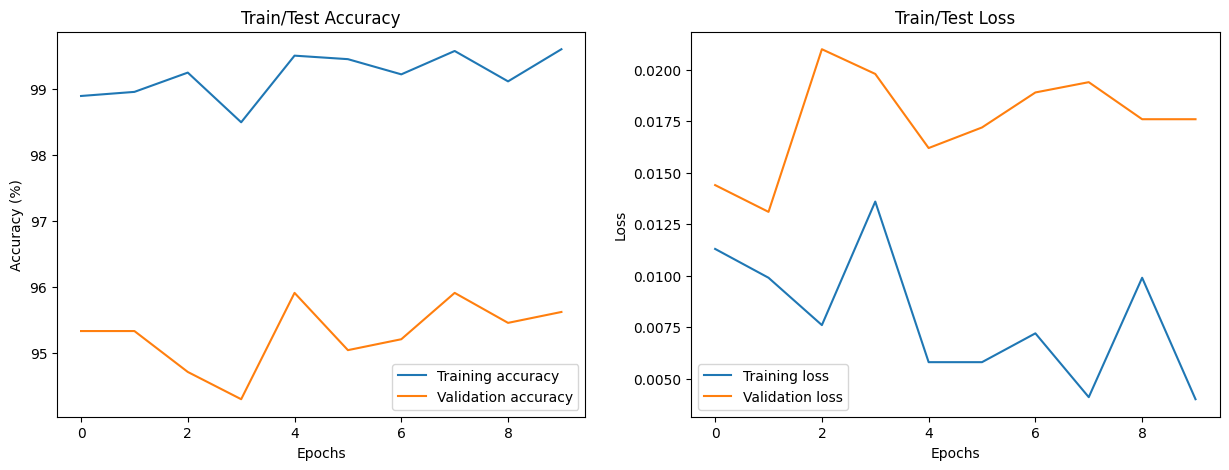

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))



ax[0].plot(total_training_accuracy_plot, label='Training accuracy')
ax[0].plot(total_Validation_accuracy_plot, label='Validation accuracy')
ax[0].set_title('Train/Test Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy (%)')
ax[0].legend()

# Loss plot
ax[1].plot(total_training_loss_plot, label='Training loss')
ax[1].plot(total_validation_loss_plot, label='Validation loss')
ax[1].set_title('Train/Test Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()


In [54]:
def predict_image(img): 
    img = Image.open(img).convert('RGB') 
    img = transform(image).to(device) 
    print(img.shape)  
    img = img.unsqueeze(0)
    prediction = model(img) 
    output = torch.argmax(prediction , axis=1).item()
    return label_encoder.inverse_transform([output])

torch.Size([3, 128, 128])


array(['dog'], dtype=object)

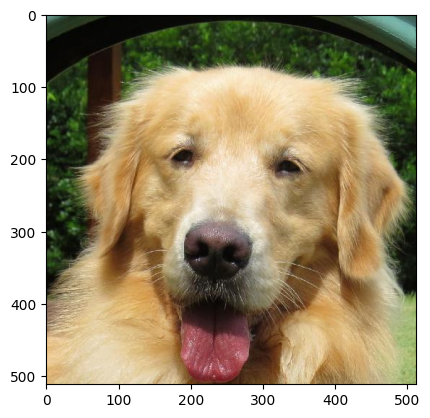

In [77]:
import random  
img_path = random.choice(df['image_path']) 
im = plt.imread(img_path) 
plt.imshow(im)
predict_image(img_path)